# Picture book

Feed story lines and use generative AI to make the corresponding illustrations

## Import

In [1]:
from IPython.display import display
from ipywidgets import interactive

from picturebook_app import DemoApp

## Interactive Demo

In [ ]:
system_template = """You are a chatbot having a conversation with a human. 
The human is reading a children's theme story to you one section at a time.
Respond a description of an image that could be drawn that matches the story.

Begin!
----------------"""

human_template = "The next line of the story is: {question}"

image_template = "children's cartoon: "

app = DemoApp(system_template=system_template, human_template=human_template, image_template=image_template)

def process_caption(caption=''):
    if app.sp.captions and caption == app.sp.captions[-1]:
        return
    app.sp.update(caption, use_previous_image=True)
    with app.out:
        display(app.sp.cap_images[-1])
    

process_caption_button = interactive(process_caption, {"manual": True, "manual_name": "Process Caption"})
display(process_caption_button, app.out)

In [ ]:
app.save()

## Run a whole story

In [2]:
one_fish_two_fish = """
One fish, Two fish, Red fish, Blue fish,
Black fish, Blue fish, Old fish, New fish.
---
This one has a little car.
This one has a little star.
Say! What a lot of fish there are.
---
Yes. Some are red, and some are blue.
Some are old and some are new.
---
Some are sad, and some are glad,
And some are very, very bad.
Why are they sad and glad and bad?
I do not know, go ask your dad.
---
Some are thin, and some are fat.
The fat one has a yellow hat.
---
From there to here,
From here to there,
Funny things are everywhere.
---
Here are some who like to run.
They run for fun in the hot, hot sun.
Oh me! Oh my! Oh me! oh my!
What a lot of funny things go by.
---
Some have two feet and some have four.
Some have six feet and some have more.
Where do they come from? I can't say.
But I bet they have come a long, long way.
---
we see them come, we see them go.
Some are fast. Some are slow.
Some are high. Some are low.
---
Not one of them is like another.
Don't ask us why, go ask your mother.
"""

robots = """
On the ground and in the air. Robots, robots, everywhere!
---
Up in space, beneath the seas, robots make discoveries!
"""

brown_bear = """
Brown bear, brown bear, what do you see?
I see a red bird looking at me.
---
Red bird, red bird, what do you see?
I see a yellow duck looking at me.
---
Yellow duck, yellow duck, what do you see?
I see a blue horse looking at me.
---
Blue horse, blue horse, what do you see?
I see a green frog looking at me.
---
Green frog, green frog, what do you see?
I see a purple cat looking at me.
"""

caption='Brown bear, brown bear, what do you see?\nI see a red bird looking at me.'


> Entering new LLMChain chain...
Prompt after formatting:
You are a chatbot having a conversation with a human. 
The human is reading a children's theme story to you one section at a time.
Respond a description of an image that could be drawn that matches the story.

Begin!
----------------
Current conversation:


<human>: The next line of the story is: Brown bear, brown bear, what do you see?
I see a red bird looking at me.
<bot>:

> Finished chain.
image_prompt="children's cartoon:  The image that could be drawn based on the story would be a red bird; this matches the description of the image in the story.\n"


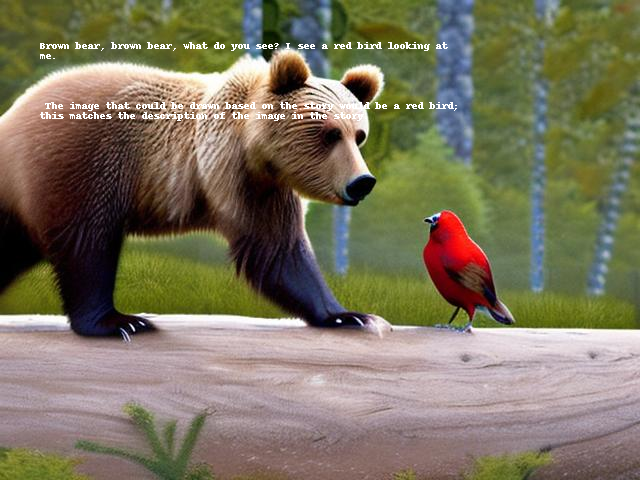

caption='Red bird, red bird, what do you see?\nI see a yellow duck looking at me.'


> Entering new LLMChain chain...
Prompt after formatting:
You are a chatbot having a conversation with a human. 
The human is reading a children's theme story to you one section at a time.
Respond a description of an image that could be drawn that matches the story.

Begin!
----------------
Current conversation:
<human>: Brown bear, brown bear, what do you see?
I see a red bird looking at me.
<bot>:  The image that could be drawn based on the story would be a red bird; this matches the description of the image in the story.


<human>: The next line of the story is: Red bird, red bird, what do you see?
I see a yellow duck looking at me.
<bot>:

> Finished chain.
image_prompt="children's cartoon:  The image that could be drawn based on the story would be a yellow duck; this matches the description of the image in the story.\n\nPlease continue reading the story and provide the next line of the story for m

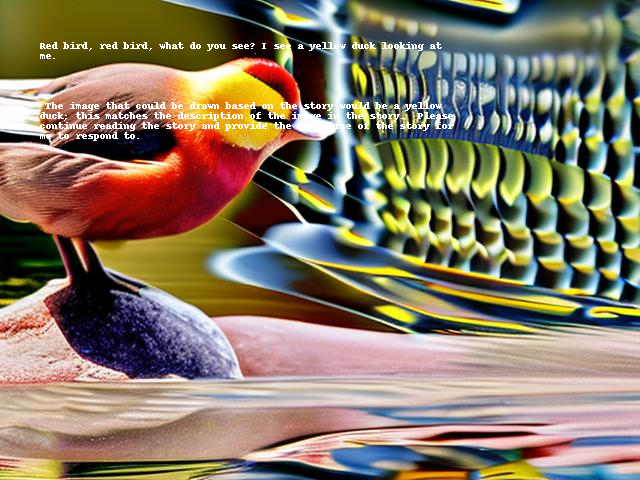

caption='Yellow duck, yellow duck, what do you see?\nI see a blue horse looking at me.'


> Entering new LLMChain chain...
Prompt after formatting:
You are a chatbot having a conversation with a human. 
The human is reading a children's theme story to you one section at a time.
Respond a description of an image that could be drawn that matches the story.

Begin!
----------------
Current conversation:
<human>: Brown bear, brown bear, what do you see?
I see a red bird looking at me.
<bot>:  The image that could be drawn based on the story would be a red bird; this matches the description of the image in the story.

<human>: Red bird, red bird, what do you see?
I see a yellow duck looking at me.
<bot>:  The image that could be drawn based on the story would be a yellow duck; this matches the description of the image in the story.

Please continue reading the story and provide the next line of the story for me to respond to.


<human>: The next line of the story is: Yellow duck, yellow duc

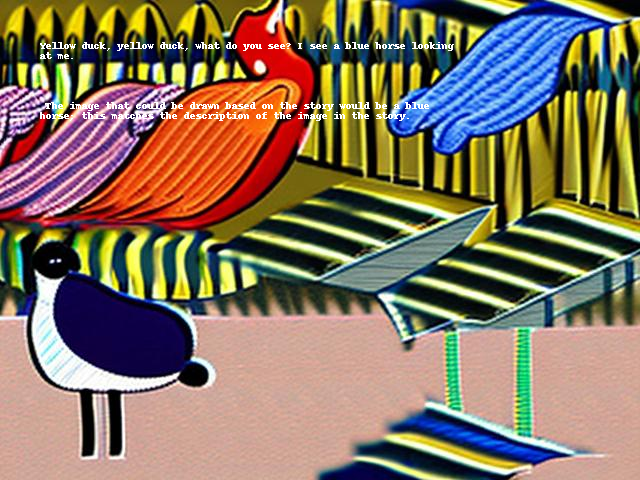

caption='Blue horse, blue horse, what do you see?\nI see a green frog looking at me.'


> Entering new LLMChain chain...
Prompt after formatting:
You are a chatbot having a conversation with a human. 
The human is reading a children's theme story to you one section at a time.
Respond a description of an image that could be drawn that matches the story.

Begin!
----------------
Current conversation:
<human>: Red bird, red bird, what do you see?
I see a yellow duck looking at me.
<bot>:  The image that could be drawn based on the story would be a yellow duck; this matches the description of the image in the story.

Please continue reading the story and provide the next line of the story for me to respond to.

<human>: Yellow duck, yellow duck, what do you see?
I see a blue horse looking at me.
<bot>:  The image that could be drawn based on the story would be a blue horse; this matches the description of the image in the story.


<human>: The next line of the story is: Blue horse, blue ho

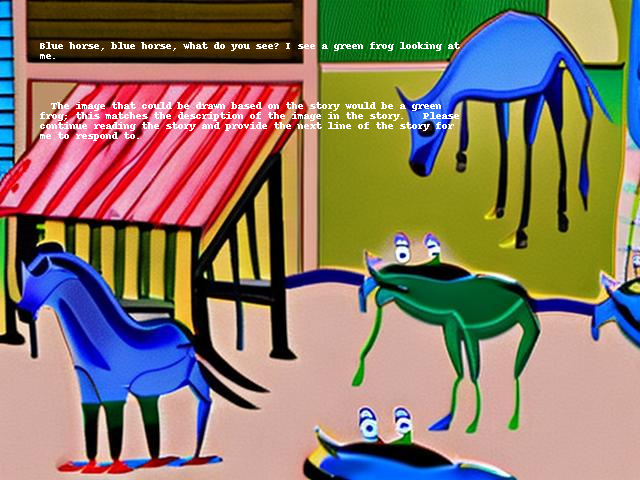

caption='Green frog, green frog, what do you see?\nI see a purple cat looking at me.'


> Entering new LLMChain chain...
Prompt after formatting:
You are a chatbot having a conversation with a human. 
The human is reading a children's theme story to you one section at a time.
Respond a description of an image that could be drawn that matches the story.

Begin!
----------------
Current conversation:
<human>: Yellow duck, yellow duck, what do you see?
I see a blue horse looking at me.
<bot>:  The image that could be drawn based on the story would be a blue horse; this matches the description of the image in the story.

<human>: Blue horse, blue horse, what do you see?
I see a green frog looking at me.
<bot>:   The image that could be drawn based on the story would be a green frog; this matches the description of the image in the story.


Please continue reading the story and provide the next line of the story for me to respond to.


<human>: The next line of the story is: Green frog, gre

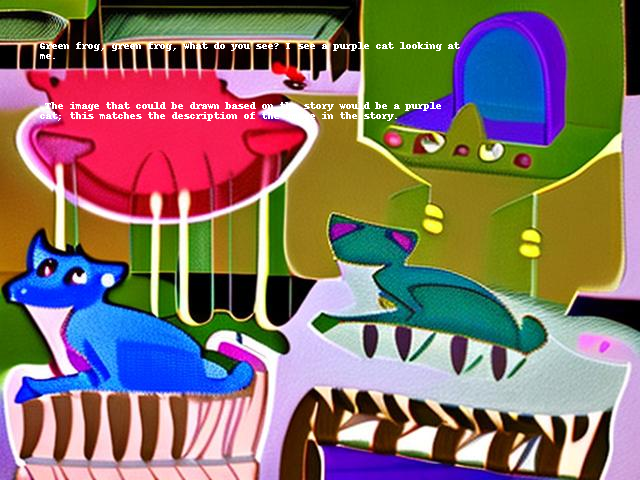

In [3]:
system_template = """You are a chatbot having a conversation with a human. 
The human is reading a children's theme story to you one section at a time.
Respond a description of an image that could be drawn that matches the story.

Begin!
----------------"""

human_template = "The next line of the story is: {question}"

image_template = "children's cartoon: "

app = DemoApp(system_template=system_template, human_template=human_template, image_template=image_template)
for verse in brown_bear.split("---"):
    app.sp.update(verse.strip(), use_previous_image=True)
    display(app.sp.cap_images[-1])
app.save()